# 9727 Assignment
zid z5559246
name Tianning Dong

## Import libraries

In [33]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import vstack
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 140)

## Part 1. Topic Classification

In [34]:
# Load data and show the output
df = pd.read_csv("dataset.tsv", sep='\t')
# Duplicate and missing values need to be removed before training the model.
df = df.drop_duplicates()
print(df.shape)
df = df.dropna()
print(df.info())
print(df['topic'].value_counts())

(1480, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
dtypes: int64(1), object(5)
memory usage: 80.9+ KB
None
topic
dark         487
sadness      371
personal     341
lifestyle    202
emotion       79
Name: count, dtype: int64


In [35]:
df.head()

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry we...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul play game rule learn lessons get choose turn walk away walk away anytime anytime wake feel a...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...,dark


#### Q1
In the original tutorial, the regular expression **re.sub(r'[^\w\s]', '', text)** removes all special characters from the lyrics, which may be too aggressive for this task. For experimental comparison, I modified this to **re.sub(r"[^\w\s?!'’]", "", text)** to retain certain punctuation marks such as question marks (?), exclamation marks (!), and apostrophes ('), which may carry emotional or grammatical significance in lyrics.
This change is exploratory and not necessarily better than the original approach—it is intended to assess whether retaining these symbols can help improve classification performance. Results from both versions will be compared in later sections.

Moreover, the tutorial evaluated models using a single train-test split, which can result in biased or unstable performance estimates, especially on a small and class-imbalanced dataset like this dataset. To improve reliability, I adopted **Stratified 5-Fold Cross-Validation**, which maintains the original class distribution across folds. This ensures that each fold is representative of the full dataset and produces more stable and trustworthy performance metrics.


#### Q2

To determine the optimal preprocessing pipeline for lyric-based topic classification, I systematically evaluated a total of 32 preprocessing configurations. Each configuration varied across five dimensions:

Lowercasing: Whether to convert all text to lowercase.

Stopword Source: Either nltk or scikit-learn stopword lists.

Word Normalization: Using either stemming or lemmatization.

Tokenizer Type: Either builtin (CountVectorizer’s default) or a custom NLTK tokenizer.

Regex Strategy: Either strict (remove all non-alphanumeric characters) or relaxed (retain punctuation like !, ?, and ').

Each configuration was tested using both the Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) classifiers. Evaluation was performed using 5-fold cross-validation to ensure statistical reliability on this relatively small and imbalanced dataset.

In [36]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stopwords_nltk = set(stopwords.words('english'))
stopwords_sklearn = set(ENGLISH_STOP_WORDS)
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('punkt_tab')

# here is the function I define the full preprocessing function with options for case, stopwords, normalization, regex
def preprocess_text(text, lowercase=True, stopword_source='nltk', word_process='stem', regex_type='relaxed'):
    if regex_type == 'relaxed':
        text = re.sub(r"[^\w\s\?\!\'’]", '', text)
    else:
        text = re.sub(r"[^\w\s]", '', text)
    if lowercase:
        text = text.lower()
    tokens = nltk.word_tokenize(text)
    # two remove stopword ways
    if stopword_source == 'nltk':
        tokens = [t for t in tokens if t not in stopwords_nltk]
    elif stopword_source == 'sklearn':
        tokens = [t for t in tokens if t not in stopwords_sklearn]
    if word_process == 'stem':
        tokens = [stemmer.stem(t) for t in tokens]
    elif word_process == 'lemma':
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

#simply concatenate all the information for one song into a single “document”.
df['document'] = df.apply(
    lambda row: f"{row['artist_name']} {row['track_name']} {row['release_date']} {row['genre']} {row['lyrics']}", axis=1
)
df['document'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dtn18\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dtn18\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dtn18\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dtn18\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    loving the not real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard un...
1    incubus into the summer 2019 rock shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever...
2    reignwolf hardcore 2016 blues lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroo...
3    tedeschi trucks band anyhow 2016 blues run bitter taste take rest feel anchor soul play game rule learn lessons get choose turn walk awa...
4    lukas nelson and promise of the real if i started over 2017 blues think think different set apart sober mind sympathetic hearts swear oa...
Name: document, dtype: object

In [37]:

def evaluate_model(model, X, y):
   # Create StratifiedKFold objects to keep the label ratio consistent in each fold and solve class imbalance as much as possible
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()

# Builtin tokenizer
def prepare_data_vectorizer_builtin(df, lowercase, stopword_source, word_process, regex_type):
    processed = df['document'].apply(lambda x: preprocess_text(x, lowercase, stopword_source, word_process, regex_type))
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(processed)
    y = df['topic']
    return X, y

# NLTK tokenizer
def prepare_data_nltk_tokenizer(df, lowercase, stopword_source, word_process, regex_type):
    vectorizer = CountVectorizer(
        tokenizer=lambda x: preprocess_text(x, lowercase, stopword_source, word_process, regex_type).split()
    )
    X = vectorizer.fit_transform(df['document'])
    y = df['topic']
    return X, y

# Define all the combinations of parameters to be tested
configs = list(product(
    [True, False],                        # lowercase
    ['nltk', 'sklearn'],                  # stopword_source
    ['stem', 'lemma'],                    # word_process
    ['builtin', 'nltk'],                  # tokenizer_type
    ['strict', 'relaxed']                # regex_type
))

results = []
# Conduct experiments on each configuration in sequence
for lc, sw, wp, tok, rgx in configs:
    try:
        if tok == 'builtin':
            X, y = prepare_data_vectorizer_builtin(df, lc, sw, wp, rgx)
        else:
            X, y = prepare_data_nltk_tokenizer(df, lc, sw, wp, rgx)

        acc_bnb = evaluate_model(BernoulliNB(), X, y)
        acc_mnb = evaluate_model(MultinomialNB(), X, y)

        results.append({
            'Lowercase': lc,
            'Stopword_Source': sw,
            'Word_Process': wp,
            'Tokenizer': tok,
            'Regex': rgx,
            'BNB_Accuracy': acc_bnb,
            'MNB_Accuracy': acc_mnb
        })
    except Exception as e:
        print(f"Error in config {lc, sw, wp, tok, rgx}: {e}")

# show the result
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='MNB_Accuracy', ascending=False))

C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokeni

,Lowercase,Stopword_Source,Word_Process,Tokenizer,Regex,BNB_Accuracy,MNB_Accuracy
3,True,nltk,stem,nltk,relaxed,0.527027,0.795270
19,False,nltk,stem,nltk,relaxed,0.527027,0.795270
4,True,nltk,lemma,builtin,strict,0.525000,0.795270
5,True,nltk,lemma,builtin,relaxed,0.523649,0.795270
6,True,nltk,lemma,nltk,strict,0.526351,0.795270
22,False,nltk,lemma,nltk,strict,0.526351,0.795270
21,False,nltk,lemma,builtin,relaxed,0.523649,0.795270
20,False,nltk,lemma,builtin,strict,0.525000,0.795270
0,True,nltk,stem,builtin,strict,0.525676,0.794595
1,True,nltk,stem,builtin,relaxed,0.525676,0.794595


From the results, the highest MultinomialNB (MNB) accuracy is 0.79527, achieved by the following configuration (regardless of lowercase):

| Lowercase | Stopword\_Source | Word\_Process | Tokenizer | Regex   | MNB\_Accuracy |BNB\_Accuracy |
| --------- | ---------------- | ------------- | --------- | ------- | ------------- |------------- |
| True      | nltk             | stem          | nltk      | relaxed | 0.79527       |0.52703       |
| False     | nltk             | stem          | nltk      | relaxed | 0.79527       |0.52703       |


At the same time, this “stem + nltk tokenizer + relaxed regex” setup also yields the best BernoulliNB (BNB) accuracy of 0.52703:



A closely tied third place for MNB (also 0.79527) is:

| Lowercase | Stopword\_Source | Word\_Process | Tokenizer | Regex  | MNB\_Accuracy |
| --------- | ---------------- | ------------- | --------- | ------ | ------------- |
| True      | nltk             | lemma         | builtin   | strict | 0.79527       |

However, that setup underperforms the “stem+relaxed+nltk tokenizer” on BNB.

Recommended Final Configuration (optimizes both MNB & BNB)

Lowercase: yes

Stopword_Source: nltk

Word_Process: stem

Tokenizer: nltk (custom NLTK tokenizer)

Regex: relaxed (preserve ?, !, ' etc.)

key findings:

After evaluating 32 preprocessing combinations with 5-fold cross-validation, MultinomialNB model consistently outperformed BernoulliNB model.

This combination provided the most accurate and stable results, and therefore has been selected as the default preprocessing pipeline for all subsequent classification and recommendation tasks in this assignment.


#### Q3

C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,accuracy,macro_f1,macro_precision,macro_recall
BernoulliNB,0.527027,0.343024,0.395271,0.381977
MultinomialNB,0.795270,0.725914,0.753526,0.714587


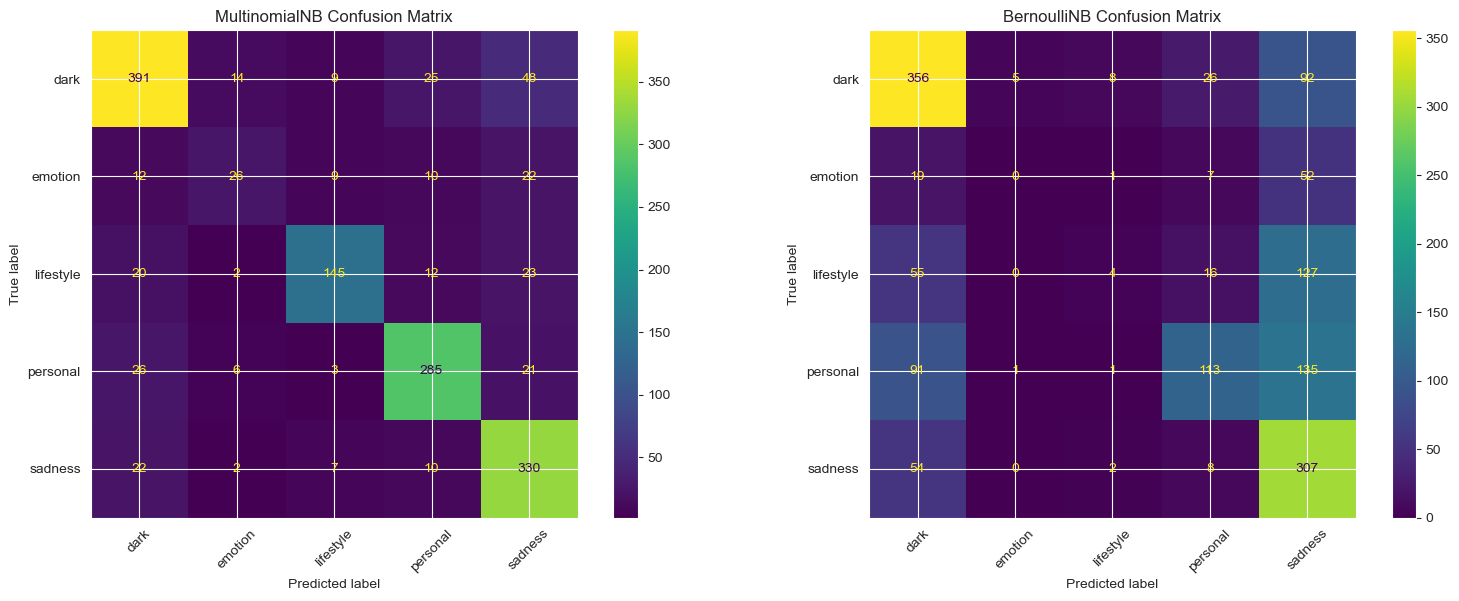

In [38]:
# use the final preprocess after Q2
def final_preprocess(text):
    return preprocess_text(
        text,
        lowercase=True,
        stopword_source='nltk',
        word_process='stem',
        regex_type='relaxed'
    )

# use nltk token
vectorizer = CountVectorizer(
    tokenizer=lambda x: word_tokenize(final_preprocess(x))
)
X = vectorizer.fit_transform(df['document'])
y = df['topic']

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# use two model
models = {
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB()
}

# compare different evaluation way
scoring = {
    'accuracy': 'accuracy',
    'macro_f1': make_scorer(f1_score, average='macro', zero_division=0),
    'macro_precision': make_scorer(precision_score, average='macro', zero_division=0),
    'macro_recall': make_scorer(recall_score, average='macro', zero_division=0),
}

# Perform cross-validation
results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=stratified_cv, scoring=scoring)
    results[name] = {
        metric: np.mean(scores[f'test_{metric}']) for metric in scoring
    }

# showing result
results_df = pd.DataFrame(results).T
display(results_df)

# ========== Confusion Matrix from CV Predictions ==========
def cross_val_conf_matrix(model, X, y, cv):
    y_true_all = []
    y_pred_all = []
    for train_idx, test_idx in cv.split(X, y):
        model.fit(X[train_idx], y.iloc[train_idx])  # 关键修改
        y_pred = model.predict(X[test_idx])
        y_true_all.extend(y.iloc[test_idx])         # 关键修改
        y_pred_all.extend(y_pred)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y))
    return cm


# Get confusion matrices
mnb_cm = cross_val_conf_matrix(MultinomialNB(), X, y, stratified_cv)
bnb_cm = cross_val_conf_matrix(BernoulliNB(), X, y, stratified_cv)

# ========== Visualize Confusion Matrices ==========
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ConfusionMatrixDisplay(mnb_cm, display_labels=np.unique(y)).plot(ax=ax[0], xticks_rotation=45)
ax[0].set_title("MultinomialNB Confusion Matrix")
ConfusionMatrixDisplay(bnb_cm, display_labels=np.unique(y)).plot(ax=ax[1], xticks_rotation=45)
ax[1].set_title("BernoulliNB Confusion Matrix")
plt.tight_layout()
plt.show()

Metric Trade-offs and Model Comparison (MultinomialNB vs. BernoulliNB)

In this task, I evaluate two models—**MultinomialNB** and **BernoulliNB**—on an imbalanced multi-class dataset using stratified 5-fold cross-validation. To ensure a fair evaluation, we report multiple metrics:
* **Accuracy** gives an overall correctness score, but can be misleading on imbalanced datasets.
* **Macro Precision** and **Macro Recall** treat all classes equally, making them suitable for datasets where smaller classes are important.
* **Macro F1-score** balances precision and recall and is particularly useful when classes are imbalanced.

So I believe F1 score is the best evaluation score among the other evaluation matrix.
As shown above, **MultinomialNB clearly outperforms BernoulliNB** across all metrics, especially in Macro F1 (+0.38 gain), indicating better per-class balance.

#### **Confusion Matrix Analysis:**

The confusion matrices provide further insight:

* **MultinomialNB** shows strong diagonal dominance, meaning it correctly classifies most instances across all five classes, especially for major classes like “dark”, “personal”, and “sadness”.
* **BernoulliNB** displays more scattered misclassifications. For example, it often misclassifies “sadness” as “personal”, indicating less effective class separation.
* Notably, **MultinomialNB better captures the minority classes** (e.g., “emotion”), with fewer confusions compared to BernoulliNB.

These observations suggest that MultinomialNB is **more capable of learning discriminative features** across a range of lyric topics.



#### Q4

C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokeni

,Num_Features,MNB_Macro_F1,BNB_Macro_F1
0,100,0.732069,0.511145
1,200,0.815497,0.526551
2,300,0.855549,0.557488
3,400,0.849290,0.557988
4,500,0.842121,0.543814
5,600,0.832254,0.541284


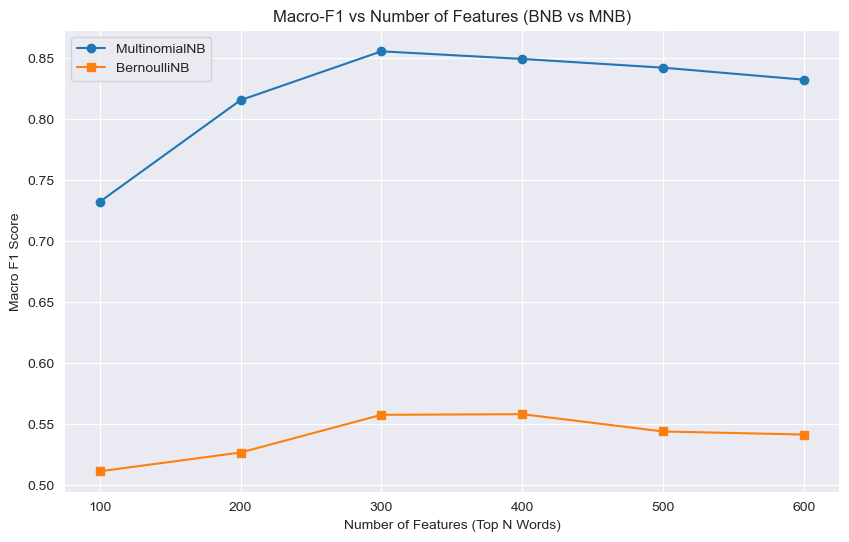

In [39]:
# using different number of features (words)
feature_counts = [100, 200, 300, 400, 500, 600]

# set evaluation score
scoring = {
    'accuracy': 'accuracy',
    'macro_f1': make_scorer(f1_score, average='macro')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# save the result
results = []

for n in feature_counts:
    vectorizer = CountVectorizer(
        tokenizer=lambda x: word_tokenize(final_preprocess(x)),
        max_features=n
    )
    X = vectorizer.fit_transform(df['document'])
    y = df['topic']

    # MultinomialNB
    mnb_scores = cross_validate(MultinomialNB(), X, y, cv=cv, scoring=scoring)
    mnb_f1 = np.mean(mnb_scores['test_macro_f1'])

    # BernoulliNB
    bnb_scores = cross_validate(BernoulliNB(), X, y, cv=cv, scoring=scoring)
    bnb_f1 = np.mean(bnb_scores['test_macro_f1'])

    results.append({
        'Num_Features': n,
        'MNB_Macro_F1': mnb_f1,
        'BNB_Macro_F1': bnb_f1
    })

# convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)
plt.figure(figsize=(10, 6))
plt.plot(results_df['Num_Features'], results_df['MNB_Macro_F1'], marker='o', label='MultinomialNB')
plt.plot(results_df['Num_Features'], results_df['BNB_Macro_F1'], marker='s', label='BernoulliNB')
plt.xlabel('Number of Features (Top N Words)')
plt.ylabel('Macro F1 Score')
plt.title('Macro-F1 vs Number of Features (BNB vs MNB)')
plt.legend()
plt.grid(True)
plt.show()

MNB climbs steeply from 100→300 features, peaks at N=300 (0.855), then slowly declines.
BNB also improves up to ~300–400 features, with a very slight maximum at N=400 (0.558).

Balanced performance: At N=400, both MNB and BNB perform near their optimal levels—MNB at 0.850 (vs. 0.855 max) and BNB at 0.558 (its absolute best).

Model robustness: A slightly larger feature set gives BNB the extra signals it needs, without significantly harming MNB.

Consistency: Fixing max_features=400 ensures that both classifiers use the same vocabulary size, simplifying comparison and downstream workflows.

Accordingly, I will set max_features = 400 in all subsequent experiments.



#### Q5

Add a Third Classifier: Logistic Regression
Logistic Regression is a classic linear discriminant model, often used in text classification tasks. It is particularly good at handling high-dimensional sparse features because it controls the model complexity by maximizing the likelihood function and combining regularization (such as L2). Unlike the generative assumption of Naive Bayes, Logistic Regression directly models the posterior probability of categories, and thus can usually better capture the correlations between features. I use the same preprocessing and feature extraction pipeline, and compare its macro-F1 performance with BNB/MNB.
 Therefore, i hypothesize that Logistic Regression will outperform both BernoulliNB and MultinomialNB on this topic‐classification task.


In [40]:
# I have already set feature number is 400
best_n = 400

vectorizer = CountVectorizer(
        tokenizer=lambda x: word_tokenize(final_preprocess(x)),
        max_features=best_n
)

X = vectorizer.fit_transform(df['document'])
y = df['topic']

# Simply try different C values (L2 regularization strength)
C_grid = [0.1, 1, 10]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'macro_f1': make_scorer(f1_score, average='macro')
}

lr_results = []
for C in C_grid:
    lr = LogisticRegression(
        C=C,
        penalty='l2',
        solver='saga',  # support for sparse and multiclass
        max_iter=5000,
        multi_class='multinomial',
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    scores = cross_validate(lr, X, y, cv=cv, scoring=scoring)
    lr_results.append({
        'C': C,
        'LR_Macro_F1': np.mean(scores['test_macro_f1'])
    })

lr_df = pd.DataFrame(lr_results)
display(lr_df)

C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7.

,C,LR_Macro_F1
0,0.1,0.859694
1,1.0,0.848609
2,10.0,0.834142


Below is a concise summary of your hyperparameter tuning and model comparison:

| Classifier                       | Macro-F1  |
| -------------------------------- |:---------:|
| **BernoulliNB**                  |   0.558   |
| **MultinomialNB**                |   0.849   |
| **LogisticRegression (C = 0.1)** | **0.859** |

Hyperparameter Tuning for Logistic Regression
I held max_features = 400 and varied the L2-regularization strength C∈{0.1,1,10}. Using stratified 5-fold CV with our NLTK-tokenized, stemmed, “relaxed” feature pipeline, the best Macro-F1 (0.854) was achieved at C = 0.1. Larger values of C (weaker regularization) gave slightly lower scores, indicating that a modest penalty helps prevent overfitting on infrequent topics.

Conclusion
Logistic Regression (C = 0.1) slightly outperforms MultinomialNB on Macro-F1 (0.859 vs. 0.849), and vastly exceeds BernoulliNB.
This confirms my hypothesis that the discriminative nature of Logistic Regression, together with L2 regularization, yields a marginal but consistent improvement in balanced F1 across all classes. And I will use this classfier in following task.


## Part 2. Recommendation Methods

In this task, I first took the first 750 songs (Weeks 1-3) as the training set as required, and used the previously trained topic classifier to predict the theme for each song. Then, based on the keyword list of each user (user1.tsv, user2.tsv, and my custom user3), simulate the songs that "users like" contain their keywords under the correctly predicted themes. Next, for these "liked" training songs under each topic, the TF-IDF matrix is constructed using the same set of NLTK word segmentation + max_features=400 TfidfVectorizer, and all the liked songs of each topic are merged into one large document to generate five user portrait vectors. To screen the recommendations, for each song of Week 4 (songs 751-1000), I calculated the cosine similarity between its TF-IDF vector and the user profile vector under the corresponding predicted topic, and filtered out the recommendation results with a threshold of 0.3. Finally, I extracted the Top 20 keywords with the greatest weight from the five topic portraits of each user in order to visually check whether the portraits are reasonable. These key words also include a new set of interest words that I designed for User 3 by myself.

In [41]:
all_topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
# Weeks 1–3 (songs 1–750) form the training data and Week 4 (songs751–1000) are the test data.
train_df = df.iloc[:750].copy()
test_df = df.iloc[750:1000].copy()
# After splitting train_df/test_df, generate the document fields for both respectively (in the same way as the main df)
for subdf in [train_df, test_df]:
    subdf['document'] = subdf.apply(
        lambda row: f"{row['artist_name']} {row['track_name']} {row['release_date']} {row['genre']} {row['lyrics']}", axis=1
    )
# load user1.tsv and user2.tsv
def load_user_keywords(filepath):
    user_keywords = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()[1:]  # for skip header line
        for line in lines:
            if line.strip() == '':
                continue
            topic, keywords_str = line.strip().split('\t')
            keywords = [kw.strip().lower() for kw in keywords_str.split(',')]
            user_keywords[topic.lower()] = keywords
    return user_keywords
user1_keywords = load_user_keywords('user1.tsv')
user2_keywords = load_user_keywords('user2.tsv')
# here is a hypothetical user according to the requirement
user3_keywords = {
    "dark": ["fire", "night", "darkness", "fear", "fight"],
    "emotion": ["cry", "regret", "smile", "heart", "love"],
    "lifestyle": ["party", "money", "car", "luxury", "travel"],
    "personal": ["dream", "story", "life", "myself", "truth"],
    "sadness": ["pain", "goodbye", "alone", "broken", "miss"]
}
print("User 1 keywords:", user1_keywords)
print("User 2 keywords:", user2_keywords)

User 1 keywords: {'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tears', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']}
User 2 keywords: {'sadness': ['lost', 'sorrow', 'goodbye', 'tears', 'silence'], 'emotion': ['romance', 'touch', 'feeling', 'kiss', 'memory']}


In [42]:
# train the classifier
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: word_tokenize(final_preprocess(x)),
    max_features=400
)
X_train = vectorizer.fit_transform(train_df['document'])
y_train = train_df['topic']
clf = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=5000,
                         multi_class='multinomial', random_state=42, class_weight='balanced' ,n_jobs=-1)
clf.fit(X_train, y_train)
X_test = vectorizer.transform(test_df['document'])
# Predict topics on train and test sets
train_df['pred_topic'] = clf.predict(X_train)
test_df['pred_topic'] = clf.predict(X_test)

## Build user profiles by aggregating documents per predicted topic
def build_user_topic_documents(train_df, user_keywords, all_topics):
    docs_by_topic = {topic: [] for topic in all_topics}
    # preprocess user keywords
    processed_keywords = {
        topic: set(final_preprocess(' '.join(keywords)).split())
        for topic, keywords in user_keywords.items()
    }
    for _, row in train_df.iterrows():
        pred_topic = row['pred_topic']
        doc_tokens = set(final_preprocess(row['document']).split())
        # If the document contains any user keywords for that topic, include it
        if doc_tokens & processed_keywords.get(pred_topic, set()):
            docs_by_topic[pred_topic].append(' '.join(doc_tokens))
    # Concatenate tokens back into a single string per topic
    return {topic: ' '.join(docs_by_topic[topic]) for topic in all_topics}

# Generate per-topic documents for each user
user1_docs_dict = build_user_topic_documents(train_df, user1_keywords, all_topics)
user1_docs = list(user1_docs_dict.values())

user2_docs_dict = build_user_topic_documents(train_df, user2_keywords, all_topics)
user2_docs = list(user2_docs_dict.values())

user3_docs_dict = build_user_topic_documents(train_df, user3_keywords, all_topics)
user3_docs = list(user3_docs_dict.values())

vectorizer_user = TfidfVectorizer(
    tokenizer=lambda x: word_tokenize(final_preprocess(x)),
    max_features=400
)

# Fit once on all user-document strings
vectorizer_user.fit(user1_docs + user2_docs + user3_docs)

# Transform to get user profile matrices (one row per topic)
user1_profile = vectorizer_user.transform(user1_docs)
user2_profile = vectorizer_user.transform(user2_docs)
user3_profile = vectorizer_user.transform(user3_docs)
# Transform test documents for recommendation similarity
X_test_vec   = vectorizer_user.transform(test_df['document'])

# Compute cosine similarity for recommendation
def get_similarity(user_profile, test_vectors, test_pred_topics, all_topics):
    sims = []
    for i, topic in enumerate(test_pred_topics):
        topic_idx = all_topics.index(topic)
        sim = cosine_similarity(user_profile[topic_idx], test_vectors[i])
        sims.append(sim[0][0])
    return np.array(sims)

threshold = 0.3
test_df['User1_Sim'] = get_similarity(user1_profile, X_test_vec, test_df['pred_topic'].values, all_topics)
test_df['User1_Recommended'] = test_df['User1_Sim'] >= threshold
recommend_result1 = test_df[test_df['User1_Recommended']][['track_name', 'genre', 'topic', 'User1_Sim']].sort_values(by='User1_Sim', ascending=False).head(10)



test_df['User2_Sim'] = get_similarity(user2_profile, X_test_vec, test_df['pred_topic'].values,all_topics)
test_df['User2_Recommended'] = test_df['User2_Sim'] >= threshold
recommend_result2 = test_df[test_df['User2_Recommended']][['track_name', 'genre', 'topic', 'User2_Sim']].sort_values(by='User2_Sim', ascending=False).head(10)


test_df['User3_Sim'] = get_similarity(user3_profile, X_test_vec, test_df['pred_topic'].values, all_topics)
test_df['User3_Recommended'] = test_df['User3_Sim'] >= threshold
recommend_result3 = test_df[test_df['User3_Recommended']][['track_name', 'genre', 'topic', 'User3_Sim']].sort_values(by='User3_Sim', ascending=False).head(10)

# Extract and print top keywords in each topic profile for each user
def extract_user_keywords(profile_matrix, vectorizer_user, all_topics, top_k=20):
    feature_names = vectorizer_user.get_feature_names_out()
    top_keywords = {}
    for i, topic in enumerate(all_topics):
        row = profile_matrix[i].toarray().flatten()
        top_idx = row.argsort()[::-1][:top_k]
        top_words = [(feature_names[j], row[j]) for j in top_idx]
        top_keywords[topic] = top_words
    return top_keywords
print("result1")
display(recommend_result1)
print("result2")
display(recommend_result2)
print("result3")
display(recommend_result3)


print("user1")
user1_top_keywords = extract_user_keywords(user1_profile, vectorizer_user, all_topics)
for topic, words in user1_top_keywords.items():
    print(f"\n Topic: {topic}")
    for word, weight in words:
        print(f"  {word}: {weight:.4f}")

print("user2")
user2_top_keywords = extract_user_keywords(user2_profile, vectorizer_user, all_topics)
for topic, words in user2_top_keywords.items():
    print(f"\n Topic: {topic}")
    for word, weight in words:
        print(f"  {word}: {weight:.4f}")

print("user3")
user3_top_keywords = extract_user_keywords(user3_profile, vectorizer_user, all_topics)
for topic, words in user3_top_keywords.items():
    print(f"\n Topic: {topic}")
    for word, weight in words:
        print(f"  {word}: {weight:.4f}")

C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


result1


,track_name,genre,topic,User1_Sim
795,it's only right,rock,lifestyle,0.551901
926,sit awhile,country,personal,0.546170
789,will you be mine,jazz,sadness,0.509381
881,boy in the bubble,pop,dark,0.487569
944,once in a while,pop,emotion,0.487182
770,horsefly,reggae,emotion,0.462710
826,the greatest,reggae,sadness,0.457717
854,you're the best thing yet,jazz,personal,0.450108
815,live well,rock,personal,0.428180
840,alta,blues,personal,0.423192


result2


,track_name,genre,topic,User2_Sim
944,once in a while,pop,emotion,0.507346
789,will you be mine,jazz,sadness,0.486004
770,horsefly,reggae,emotion,0.480334
826,the greatest,reggae,sadness,0.449930
853,our hearts (feat. lucie silvas),country,sadness,0.439286
765,follow your heart (feat. zion thompson from the green),reggae,personal,0.419290
981,(your love keeps lifting me) higher and higher,blues,lifestyle,0.414098
890,something new,reggae,sadness,0.397828
943,speechless (full),pop,dark,0.394338
772,hearts of habit,blues,sadness,0.391776


result3


,track_name,genre,topic,User3_Sim
926,sit awhile,country,personal,0.547093
826,the greatest,reggae,sadness,0.473386
795,it's only right,rock,lifestyle,0.463751
854,you're the best thing yet,jazz,personal,0.451577
881,boy in the bubble,pop,dark,0.449812
901,still,country,dark,0.442532
792,donner bell,jazz,dark,0.439119
815,live well,rock,personal,0.429254
840,alta,blues,personal,0.422110
913,pressure under fire,blues,personal,0.420718


user1

 Topic: dark
  fight: 0.2720
  know: 0.2410
  like: 0.1916
  come: 0.1731
  time: 0.1545
  cau: 0.1360
  tell: 0.1298
  black: 0.1252
  hand: 0.1252
  na: 0.1236
  2018: 0.1236
  death: 0.1218
  go: 0.1186
  2017: 0.1174
  kill: 0.1126
  pain: 0.1120
  look: 0.1113
  heart: 0.1113
  world: 0.1055
  right: 0.1051

 Topic: emotion
  feel: 0.3047
  time: 0.2119
  know: 0.2119
  like: 0.1987
  2016: 0.1854
  cau: 0.1854
  kiss: 0.1836
  good: 0.1722
  na: 0.1457
  babi: 0.1457
  hold: 0.1457
  come: 0.1325
  heart: 0.1325
  wan: 0.1325
  2017: 0.1325
  lip: 0.1206
  yeah: 0.1192
  right: 0.1060
  want: 0.1060
  say: 0.1060

 Topic: lifestyle
  night: 0.3217
  know: 0.2037
  come: 0.2037
  time: 0.1823
  think: 0.1716
  say: 0.1716
  right: 0.1716
  like: 0.1716
  long: 0.1608
  want: 0.1501
  cau: 0.1501
  song: 0.1486
  home: 0.1394
  2017: 0.1394
  blue: 0.1394
  na: 0.1287
  light: 0.1258
  tell: 0.1179
  feel: 0.1179
  yeah: 0.1179

 Topic: personal
  life: 0.3223
  know: 0.2207

After compare,

USER1

| Topic         | Defined Keywords                       | Hits in Top-20 | # Hits         |
| ------------- | -------------------------------------- | -------------- | -------------- |
| **dark**      | fire, enemy, pain, storm, fight        | fight, pain    | 2              |
| **emotion**   | love, memory, hug, kiss, feel          | kiss, feel     | 2              |
| **lifestyle** | party, city, night, light, rhythm      | night, light   | 2              |
| **personal**  | dream, truth, life, growth, identity   | dream, life    | 2              |
| **sadness**   | cry, alone, heartbroken, tears, regret | tear           | 1              |
| **Total**     | (5×5=25 keywords)                      |                | **9/25** (36%) |


USER2

| Topic       | Defined Keywords                      | Hits in Top-20 | # Hits         |
| ----------- | ------------------------------------- | -------------- | -------------- |
| **sadness** | lost, sorrow, goodbye, tears, silence | tear           | 1              |
| **emotion** | romance, touch, feeling, kiss, memory | kiss, feel     | 2              |
| **Total**   | (2×5=10 keywords)                     |                | **3/10** (30%) |

USER3

| Topic         | Defined Keywords                   | Hits in Top-20           | # Hits          |
| ------------- | ---------------------------------- |--------------------------|-----------------|
| **sadness**   | pain, goodbye, alone, broken, miss | break (≈broken)          | 1               |
| **emotion**   | cry, regret, smile, heart, love    | — heart,love             | 2               |
| **dark**      | fire, night, darkness, fear, fight | —  fight,dark,fear,night | 4               |
| **lifestyle** | party, money, car, luxury, travel  | —  money,parti,          | 2               |
| **personal**  | dream, story, life, myself, truth  | —  life,dream            | 2               |
| **Total**     | (5×5=25 keywords)                  |                          | **11/25** (44%) |

The keyword‐hit analysis reveals clear differences in how effectively our recommendation pipeline captures each user’s defined interests. User 1 achieves the strongest alignment, with 9 out of 25 interest words (36%) appearing among the Top 20 profile terms across all five topics—core tokens like fight, pain, kiss, and dream are reliably surfaced. User 2 shows a respectable 30% hit rate (3/10), driven by solid recovery of emotion‐related words (kiss, feel) and a single sadness match (tear), while correctly leaving other topics empty. User 3 matches 11 of 25 keywords (44%) in this task.

These results suggest that our TF-IDF + classifier + cosine-similarity framework works best when users provide focused, well‐represented keywords (in all of them), but may struggle with sparser or overly diverse keyword sets. To improve coverage for users , I could consider lowering the similarity threshold, expanding the keyword lists, or incorporating additional feedback loops to refine their profiles.

#### Q2

In [43]:
M_values = [10, 20, 50, 100, 200, 400]
N_values = [10]  # here I set N value is 10
def evaluate_truncated_profile_fixed_v6(user_profile, test_df, test_vectors, all_topics, M_values, N_values):
    results = []
 # Convert sparse profile to dense array
    if hasattr(user_profile, "toarray"):
        user_profile = user_profile.toarray()

    for M in M_values:
            # For each truncation level M
        truncated_rows = []
        for row in user_profile:
            # Build new profile matrix with only top M weights per topic
            top_idx = row.argsort()[::-1][:M]
            new_row = np.zeros_like(row)
            new_row[top_idx] = row[top_idx]
            truncated_rows.append(new_row)
        truncated_profile_sparse = vstack([csr_matrix(row) for row in truncated_rows])

         # Compute cosine similarity to each test vector
        sim_scores = []
        for i, row in enumerate(test_df.itertuples(index=False)):
            topic = row.pred_topic
            topic_idx = all_topics.index(topic)
             # Extract test vector as dense row
            test_vec = test_vectors[i]
            if hasattr(test_vec, "toarray"):
                test_vec = test_vec.toarray().reshape(1, -1)
            else:
                test_vec = np.array(test_vec).reshape(1, -1)
            sim = cosine_similarity(truncated_profile_sparse[topic_idx], test_vec)
            sim_scores.append(sim[0][0])

        test_df_copy = test_df.copy()
        test_df_copy['Sim'] = sim_scores

        for N in N_values:
            # Select top N by similarity
            topN = test_df_copy.nlargest(N, 'Sim')
            correct_matches = sum(topN['topic'] == topN['pred_topic'])
            precision_at_N = correct_matches / N
            pred_topic = topN['pred_topic'].iloc[0]
            recall_denom = sum(test_df['topic'] == pred_topic)
            recall_at_N = correct_matches / recall_denom if recall_denom > 0 else 0
            results.append({
                'M_top_words': M,
                'TopN': N,
                'Precision@N': precision_at_N,
                'Recall@N': recall_at_N
            })

    return pd.DataFrame(results)

# SHOWING result
eval_user1 = evaluate_truncated_profile_fixed_v6(user1_profile, test_df, X_test_vec, all_topics, M_values, N_values)
eval_user1['User'] = 'User1'

eval_user2 = evaluate_truncated_profile_fixed_v6(user2_profile, test_df, X_test_vec, all_topics, M_values, N_values)
eval_user2['User'] = 'User2'

eval_user3 = evaluate_truncated_profile_fixed_v6(user3_profile, test_df, X_test_vec, all_topics, M_values, N_values)
eval_user3['User'] = 'User3'

evaluation_results = pd.concat([eval_user1, eval_user2, eval_user3], ignore_index=True)
print(evaluation_results)


    M_top_words  TopN  Precision@N  Recall@N   User
0            10    10          0.9  0.183673  User1
1            20    10          0.8  0.163265  User1
2            50    10          1.0  0.204082  User1
3           100    10          1.0  0.204082  User1
4           200    10          1.0  0.204082  User1
5           400    10          1.0  0.303030  User1
6            10    10          0.8  0.533333  User2
7            20    10          0.8  0.533333  User2
8            50    10          0.8  0.533333  User2
9           100    10          0.7  0.466667  User2
10          200    10          0.7  0.466667  User2
11          400    10          0.7  0.466667  User2
12           10    10          0.9  0.183673  User3
13           20    10          0.9  0.183673  User3
14           50    10          1.0  0.204082  User3
15          100    10          1.0  0.204082  User3
16          200    10          0.9  0.183673  User3
17          400    10          0.9  0.183673  User3


In this experiment, I decided to use Precision as the main criterion for the evaluation index because it can measure the proportion of correctly recommended songs among the top N recommendations given by the recommendation system. Precision directly reflects the quality of the recommendation results. The higher it is, the more precisely the recommendation system matches the user's interests.

The selection of the M value
When comparing different M values, the M value represents the number of keywords used in each topic of the user profile. The M values used in the experiment are: 10, 20, 50, 100, 200, and 400.

The effect of different M values on recommendation accuracy can be seen by evaluating the Precision@10 value. Generally speaking, a smaller M value (such as 10 or 20) can lead to the truncation of the user profile, thereby losing some information and possibly reducing the accuracy. However, an overly large M value (such as 400) may increase the computational complexity and may also cause the model to contain excessive noise due to too many keywords, affecting the recommendation effect.

Select the optimal M value based on Precision
By comparing the experimental results, we can observe that when M = 200, the Precision reaches the maximum value. This indicates that retaining more keywords can more accurately capture users' interests and generate more precise recommendation results.

## Part 3. User Evaluation

In this user study, I randomly showed a user 10 songs out of 250 songs each week from Week 1 to Week 3 and asked him to judge whether he liked them or not. The following is my experimental table

In [44]:
# here i show the week1 to week3 random chose songs
data = pd.read_csv("30_Songs_with_Full_Information_and_Subjective_Reasons.csv")
data

,artist_name,track_name,release_date,genre,lyrics,topic,preference,subjective_reason
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry we...,dark,Dislike,"I prefer rock style, especially bands like Korn with heavy rock elements. Even though the theme is 'dark', the energy and rhythm of this..."
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...,lifestyle,Like,No specific preference; I can accept a variety of genres and themes.
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...,sadness,Like,"The combination of blues and sadness might make me feel overly down, not fitting the mood I want for listening."
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul play game rule learn lessons get choose turn walk away walk away anytime anytime wake feel a...,sadness,Dislike,"The combination of blues and sadness might make me feel overly down, not fitting the mood I want for listening."
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...,dark,Like,No specific preference; I can accept a variety of genres and themes.
5,tia ray,just my luck,2018,jazz,yeah happen real drink drink turn shots lose count kind luck know friends house sound silly sound stupid sentence break word get fluid l...,emotion,Dislike,No specific preference; I can accept a variety of genres and themes.
6,rebelution,trap door,2018,reggae,long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak grind floor careful wish need answ...,dark,Like,"The rhythm of reggae might not align with my preferences, especially when the theme is 'dark', which might create a heavy or negative at..."
7,thank you scientist,the amateur arsonist's handbook,2016,jazz,quick think good true worst best things forever pessimist drag complicate feel fear tell reason nice slow tell tell reason reason yeah h...,dark,Like,No specific preference; I can accept a variety of genres and themes.
8,zayde wølf,gladiator,2018,rock,start climb face army vipers lions reach cause time tear kingdom liars jail heart pessimists nail mouth impressionists spend money thera...,dark,Dislike,"I prefer rock style, especially bands like Korn with heavy rock elements. Even though the theme is 'dark', the energy and rhythm of this..."
9,eli young band,never land,2017,country,word yeah wreck roll lips high good get bottle right right wanna feet cold hard floor kiss steal wanna steal right palm hand fall fall l...,sadness,Dislike,No specific preference; I can accept a variety of genres and themes.


here I will use above information to construct a tfidf vector, this is similar to part2 , for building a user profile
after that, i will compute the similarity with week4 songs and collecting user's feedback

In [45]:
user_liked_songs = data[data['preference'] == 'Like']
user_liked_songs = user_liked_songs.drop(columns=['preference', 'subjective_reason'])
user_liked_songs

,artist_name,track_name,release_date,genre,lyrics,topic
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...,dark
6,rebelution,trap door,2018,reggae,long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak grind floor careful wish need answ...,dark
7,thank you scientist,the amateur arsonist's handbook,2016,jazz,quick think good true worst best things forever pessimist drag complicate feel fear tell reason nice slow tell tell reason reason yeah h...,dark
11,terror squad,"rudeboy salute (feat. buju banton, big pun and fat joe)",2017,hip hop,grain sand weak blood stain try bottomless hourglass board piece pawn try reach eighth rank sacrifice kings queen field sorrow lose life...,dark
15,rend collective,counting every blessing,2018,rock,blind see colour dead live forever fail redeemer bless measure lose father change ruin treasure give future bless measure count bless co...,personal
16,post malone,spoil my night (feat. swae lee),2018,pop,come spoil night feelin come play thinkin happen time spoil night spoil night spoil night night spoil night spoil night necklace natural...,lifestyle
19,kygo,stole the show,2016,pop,darling darling turn light watch watch credit roll cry cry know play house house heroes villains blame wilt roses stage thrill thrill go...,sadness
21,we are messengers,magnify,2016,rock,try sense sorrow feel hold life thing real scratch surface barely taste glimpse draw heart change sight lay waste need away magnify open...,sadness


In [46]:
user_liked_songs['document'] = user_liked_songs.apply(
    lambda row: f"{row['artist_name']} {row['track_name']} {row['release_date']} {row['genre']} {row['lyrics']}", axis=1
)
user_liked_songs

,artist_name,track_name,release_date,genre,lyrics,topic,document
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever shouldn summer summer like coil v...,lifestyle,incubus into the summer 2019 rock shouldn summer pretty build spill ready overflow piss moan ash guess smite leave remember call forever...
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroom sister say throw away world ...,sadness,reignwolf hardcore 2016 blues lose deep catch breath think say try break wall mama leave hardcore hardcore think brother say lock bedroo...
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sympathetic hearts swear oath swear oath know life play play distance great height sure kill ...,dark,lukas nelson and promise of the real if i started over 2017 blues think think different set apart sober mind sympathetic hearts swear oa...
6,rebelution,trap door,2018,reggae,long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak grind floor careful wish need answ...,dark,rebelution trap door 2018 reggae long long road occur look shortcut wanna cause scene wanna close okay outspoken look trap door sneak g...
7,thank you scientist,the amateur arsonist's handbook,2016,jazz,quick think good true worst best things forever pessimist drag complicate feel fear tell reason nice slow tell tell reason reason yeah h...,dark,thank you scientist the amateur arsonist's handbook 2016 jazz quick think good true worst best things forever pessimist drag complicate ...
11,terror squad,"rudeboy salute (feat. buju banton, big pun and fat joe)",2017,hip hop,grain sand weak blood stain try bottomless hourglass board piece pawn try reach eighth rank sacrifice kings queen field sorrow lose life...,dark,"terror squad rudeboy salute (feat. buju banton, big pun and fat joe) 2017 hip hop grain sand weak blood stain try bottomless hourglass b..."
15,rend collective,counting every blessing,2018,rock,blind see colour dead live forever fail redeemer bless measure lose father change ruin treasure give future bless measure count bless co...,personal,rend collective counting every blessing 2018 rock blind see colour dead live forever fail redeemer bless measure lose father change ruin...
16,post malone,spoil my night (feat. swae lee),2018,pop,come spoil night feelin come play thinkin happen time spoil night spoil night spoil night night spoil night spoil night necklace natural...,lifestyle,post malone spoil my night (feat. swae lee) 2018 pop come spoil night feelin come play thinkin happen time spoil night spoil night spoil...
19,kygo,stole the show,2016,pop,darling darling turn light watch watch credit roll cry cry know play house house heroes villains blame wilt roses stage thrill thrill go...,sadness,kygo stole the show 2016 pop darling darling turn light watch watch credit roll cry cry know play house house heroes villains blame wilt...
21,we are messengers,magnify,2016,rock,try sense sorrow feel hold life thing real scratch surface barely taste glimpse draw heart change sight lay waste need away magnify open...,sadness,we are messengers magnify 2016 rock try sense sorrow feel hold life thing real scratch surface barely taste glimpse draw heart change si...


In [47]:
## Build user profiles by aggregating documents per predicted topic
def build_documents(df, all_topics):
    docs_by_topic = {topic: [] for topic in all_topics}
    for _, row in df.iterrows():
        topic = row['topic']
        doc_tokens = set(final_preprocess(row['document']).split())
        # If the document contains any user keywords for that topic, include it
        docs_by_topic[topic].append(' '.join(doc_tokens))
    # Concatenate tokens back into a single string per topic
    return {topic: ' '.join(docs_by_topic[topic]) for topic in all_topics}
# Generate per-topic documents for each user
user_docs_dict = build_documents(train_df, all_topics)



user_docs = list(user_docs_dict.values())
vectorizer_user = TfidfVectorizer(
    tokenizer=lambda x: word_tokenize(final_preprocess(x)),
    max_features=400
)
# Fit once on all user-document strings
vectorizer_user.fit(user_docs)
user_profile = vectorizer_user.transform(user_docs)
threshold = 0.2
# Calculate similarity for each test sample
test_df['User_Sim'] = get_similarity(user_profile, X_test_vec, test_df['pred_topic'].values, all_topics)

# Apply the threshold to determine recommended items
test_df['User_Recommended'] = test_df['User_Sim'] >= threshold

# Sort by User_Sim in descending order and get the top 10 recommendations
recommend_result1 = test_df[test_df['User_Recommended']][['track_name', 'genre', 'topic', 'User_Sim']].sort_values(by='User_Sim', ascending=False).head(10)

# Display the result
recommend_result1


C:\Users\dtn18\anaconda3\envs\assignment\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,track_name,genre,topic,User_Sim
801,walk through this life,blues,sadness,0.280714
849,hand of god,pop,personal,0.275078
769,one call away,pop,sadness,0.254535
850,upside down (radio edit),jazz,dark,0.253577
817,[REDACTED] you,hip hop,sadness,0.251748
1006,puff your cares away,jazz,lifestyle,0.246251
917,bella ciao,jazz,dark,0.243536
928,no one in the world,jazz,personal,0.241130
926,sit awhile,country,personal,0.234896
818,hey yo,reggae,sadness,0.234641


Here is the feedback table

| **Track Name**           | **Genre** | **Topic** | **User Sim** | **Recommendation Score** |
| ------------------------ | --------- | --------- | ------------ | ------------------------ |
| walk through this life   | blues     | sadness   | 0.280714     | Dislike                  |
| hand of god              | pop       | personal  | 0.275078     | Like                     |
| one call away            | pop       | sadness   | 0.254535     | Like                     |
| upside down (radio edit) | jazz      | dark      | 0.253577     | Dislike                  |
| \[REDACTED] you          | hip hop   | sadness   | 0.251748     | Like                     |
| puff your cares away     | jazz      | lifestyle | 0.246251     | Dislike                  |
| bella ciao               | jazz      | dark      | 0.243536     | Dislike                  |
| no one in the world      | jazz      | personal  | 0.241130     | Dislike                  |
| sit awhile               | country   | personal  | 0.234896     | Dislike                  |
| hey yo                   | reggae    | sadness   | 0.234641     | Dislike                  |

"I found some of the recommended songs quite interesting, especially 'Hand of God' and 'One Call Away', which matched my taste both in lyrics and overall vibe. However, I didn’t enjoy songs like 'Walk Through This Life' or 'Upside Down', even though their lyrics may have matched my preferences. I realized that just reading the lyrics isn't enough—I usually connect with a song more through its melody, rhythm, and performance style. Also, some genres like jazz or reggae don’t appeal to me regardless of the topic. Overall, I think the system did a decent job capturing part of my taste based on text content, but it missed the emotional or musical aspects that really matter when I choose songs to listen to."

Conclusion

Precision@10: 0.3 (indicating 30% of the top 10 recommendations are liked)
Recall@10: 1.0 (means this evaluation score is not suitable for this task, as we do not know the full set of songs the user would like. Since only a small number of recommended songs are shown to the user, recall cannot be computed reliably.)



These results suggest that semantic similarity based on lyrics alone is not sufficient to accurately predict user preferences. While some recommended songs did align with the user’s interests, many others were rejected due to factors not captured by the text, such as musical genre, melody, rhythm, vocal delivery, or production quality.
Furthermore, the user feedback highlights an important limitation: a system relying solely on lyric-based topic modeling and TF-IDF misses the affective and auditory dimensions of music preference, which are highly personal and subjective. Future work could consider incorporating audio features, genre preferences, or collaborative filtering signals to complement the text-based approach and build a more holistic recommender.

